In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cupy as cp
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from skopt import BayesSearchCV
import xgboost as xgb
import os
import re

In [3]:
datasets = pd.read_csv('datasets.csv')
datasets = datasets[~datasets['study_id'].isin(['Ho2020M', 'Ho2020F'])]

data_dir = "exported_matrices"
output_dir = "label_transfer_model_output"
random_seed = 12345

hyperparams = pd.read_csv('hyperparams.csv')

## Convenience functions

In [4]:
def load_data(dataset: str, test_size: float = 0.2) -> tuple[pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray]:
    """
    Loads the data for a single dataset.

    Parameters
    ----------

    dataset : str
        The name of the dataset, e.g. Cheung2018M.
    test_size : float, optional, default = 0.1
        The size of the test set. Defaults to 0.1, i.e. 10% of the data is used for training and 90% for testing.

    Returns
    -------

    (expr_data_train, expr_data_test, labels_data_train, labels_data_test) : tuple[pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray]
        The expression data and labels for the training and test sets.
    """
    expr_data = pd.read_csv(os.path.join(
        data_dir, f"{dataset}_expression.csv"), index_col=0)
    expr_data = expr_data.T

    labels_data = pd.read_csv(os.path.join(
        data_dir, f"{dataset}_clusters.csv"), index_col=0)
    labels_data = labels_data['Cluster'].values

    expr_data_train, expr_data_test, labels_data_train, labels_data_test = train_test_split(
        expr_data, labels_data, train_size=1.0-test_size, random_state=random_seed)

    print(
        f"Loaded data for {dataset}.\nTrain: {len(expr_data_train)}\nTest: {len(expr_data_test)}")

    return (expr_data_train, expr_data_test, labels_data_train, labels_data_test)


def get_hyperparameters(dataset: str) -> dict:
    """
    Returns the model hyperparameters for a given dataset.

    Parameters
    ----------
    dataset: str
        The name of the dataset.

    Returns
    -------
    hyperparameters : dict
        The hyperparameters for the given dataset.        
    """

    hyperparams = pd.read_csv('hyperparams.csv')

    assert (
        dataset in hyperparams['dataset'].values), f"Dataset {dataset} not found. Possible values are {hyperparams['dataset'].values}"

    return hyperparams[hyperparams['dataset'] == dataset].to_dict(orient='records')[0]


def find_best_model(dataset: str) -> str | None:
    """
    Finds the best model for a given dataset.

    Parameters
    ----------
    dataset: str
        The name of the dataset.

    Returns
    -------
    best_model : str | None
        The name of the best model, or None if no models are found.
    """

    all_models = [f for f in os.listdir(output_dir) if (
        f.endswith('.json') and "_f1_" in f)]

    pattern = re.compile(r'^(.+?)(M|F)_(\d{8}-\d{6})_f1_(\d+\.\d+)\.json$')

    # Extract studynames
    studies = []
    dates = []
    f1s = []

    for filename in all_models:
        if match := pattern.match(filename):
            studies.append(match[1] + match[2])
            dates.append(match[3])
            f1s.append((match[4]))

    df = pd.DataFrame({'study': studies, 'date': dates, 'f1': f1s})
    print(df)
    df = df[df['study'] == dataset]
    if len(df) == 0:
        return None

    df = df.sort_values(by='f1', ascending=False)

    return f"{df.iloc[0]['study']}_{df.iloc[0]['date']}_f1_{df.iloc[0]['f1']}.json"


def evaluate_model(model: xgb.XGBClassifier, expr_test: np.ndarray, cluster_test: np.ndarray, num_classes: int) -> tuple[np.ndarray, np.ndarray, dict]:
    """
    Evaluates a model on a test set.

    Parameters
    ----------

    model : xgb.XGBClassifier
        The fitted model to evaluate.
    expr_test : np.ndarray
        The expression data for the test set.
    cluster_test : np.ndarray
        The true labels for the test set.
    num_classes : int
        The number of classes in the dataset.

    Returns
    -------

    (predictions, probabilities, metrics) : tuple[np.ndarray, np.ndarray, dict]
        The predictions, probabilities, and evaluation metrics for the model.        
    """

    # Evaluate the model
    predictions = model.predict(expr_test)
    probabilities = model.predict_proba(expr_test)

    # Binarize the output
    y_test_binarized = label_binarize(
        cluster_test, classes=np.arange(num_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    threshold = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(
            y_test_binarized[:, i], probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], threshold["micro"] = roc_curve(
        y_test_binarized.ravel(), probabilities.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # Compute macro-average ROC curve and ROC area
    all_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= num_classes
    macro_auc = auc(all_fpr, mean_tpr)

    return (predictions, probabilities, {
        'confusion_matrix': confusion_matrix(cluster_test, predictions),
        'f1_score': f1_score(cluster_test, predictions, average='macro'),
        'fpr': fpr,
        'tpr': tpr,
        'threshold': threshold,
        'roc_auc': roc_auc,
        'macro_auc': macro_auc,
        'all_fpr': all_fpr,
        'mean_tpr': mean_tpr
    })

# Hyperparameter tuning

In [5]:
print(datasets['study_id'].unique())

['Ruf_Zamojski2021F' 'Ruf_Zamojski2021M' 'Lopez2021M' 'Allensworth2021F'
 'Vennekens2021M' 'Mayran2019M' 'Cheung2018M' 'Kucka2021F' 'Fletcher2019F'
 'Fletcher2019M']


Change this to the dataset to optimise

In [6]:
study_id = 'Lopez2021M'

Sweep through the hyperparameters of the model to find the best combination of hyperparameters.
Choose grid search or Bayesian optimisation on selected hyperparameters.

In [27]:
hp = get_hyperparameters(study_id)

search_type = 'grid' # or 'bayes'; note that bayes takes a long time to run (20-40 minutes)

assert search_type in ['grid', 'bayes'], "Invalid search type. Must be 'grid' or 'bayes'."

model_params = {
    'device': 'cuda',
    'objective': 'multi:softmax',
    'num_class': hp['num_classes'],
    'max_depth': hp['max_depth'],
    'learning_rate': hp['learning_rate'],
    'gamma': hp['gamma'],
    'n_estimators': hp['n_estimators'],
    'subsample': hp['subsample'],
    'colsample_bytree': hp['colsample_bytree']
}

# Initialize the XGBoost classifier
model = xgb.XGBClassifier(**model_params, eval_metric='mlogloss', verbosity=0)
scorer = make_scorer(f1_score, average='macro')

# Note: this is deterministic as we are using the same random seed
expr_train, _, cluster_train, _ = load_data(study_id)

if search_type == 'grid':    
    print("Performing grid search...")
    # Note that GridSearchCV will overwrite the model_params we set here when it performs the grid search
    # A 3x4 grid search will take approximately 6 minutes
    param_grid = {
    # 'n_estimators': [50, 100, 200, 300, 500],
    # 'learning_rate': [0.001, 0.01, 0.1, 0.25, 0.5],
    # 'gamma': [0, 0.1, 0.25, 0.5, 0.9],
    'max_depth': [5, 6, 7, 8, 9],
    # 'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0]
    }

    # Set up the K-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf,
                            scoring=scorer, n_jobs=-1)

    # Perform the grid search. Note that GridSearchCV will only use np.ndarray as input, rather than the much faster xgboost.DMatrix
    # We could use the internal functions of XGBoost to speed this up, but we'd lose the sklearn integration (and convenience)
    # Given that these are small datasets and we only really need to run this once, it's not worth the effort
    grid_search.fit(expr_train, cluster_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print(f'Best Hyperparameters: {best_params}')

elif search_type == 'bayes':
    print("Performing Bayesian search...")
    param_space = {
        # 'n_estimators': (50, 250, 500),
        #'learning_rate': (0.01, 0.5, 'log-uniform'),
        # 'max_depth': (3, 7),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0),
        # 'gamma': (0, 0.5)
    }

    bayes_search = BayesSearchCV(estimator=model,
                                search_spaces=param_space,
                                scoring=scorer,
                                n_iter=100,  # Number of parameter settings sampled
                                cv=5,
                                n_jobs=-1,
                                verbose=1,
                                random_state=random_seed,
                                return_train_score=True)

    bayes_search.fit(expr_train, cluster_train)
    # Get the best hyperparameters
    best_params = bayes_search.best_params_
    print(f'Best Hyperparameters for {study_id}:')
    for key, value in best_params.items():
        if key in model_params:
            print(f'\t{key}: {value}')

Loaded data for Lopez2021M.
Train: 283
Test: 71
Performing grid search...
Best Hyperparameters: {'colsample_bytree': 0.8, 'max_depth': 9}


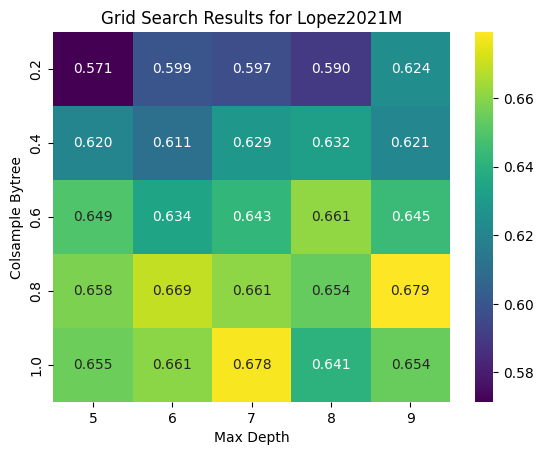

In [28]:
if search_type == 'grid':
    results = pd.DataFrame(grid_search.cv_results_)
    params = list(results['params'][0].keys()) 
    pivot_df = results.pivot_table(index=[f'param_{params[0]}'], columns=[f'param_{params[1]}'], values='mean_test_score')   
    pivot_df.index = pivot_df.index.astype(float)
    sns.heatmap(data = pivot_df, cmap='viridis', annot=True, fmt='.3f')    
    plt.xlabel(params[1].replace('_', ' ').title())
    plt.ylabel(params[0].replace('_', ' ').title())
    plt.title(f'Grid Search Results for {study_id}')
    plt.show()
else:
    # Plot the results
    results = pd.DataFrame(bayes_search.cv_results_)
    sns.pairplot(results[['mean_test_score', 'param_n_estimators', 'param_max_depth']],  # , 'param_max_depth', 'param_gamma', 'param_subsample', 'param_colsample_bytree']],
                 hue='mean_test_score', palette='viridis')
    plt.title(f'Bayesian Optimization Results for {study_id}')
    plt.show()

In [29]:
# Evaluate the model
model = xgb.XGBClassifier(**best_params, eval_metric='mlogloss', verbosity=0)
expr_train, expr_test, cluster_train, cluster_test = load_data(study_id)
model.fit(expr_train, cluster_train) # Fit on the whole training set

predictions, probabilities, metrics = evaluate_model(model, expr_test, cluster_test, hp['num_classes'])

Loaded data for Lopez2021M.
Train: 283
Test: 71


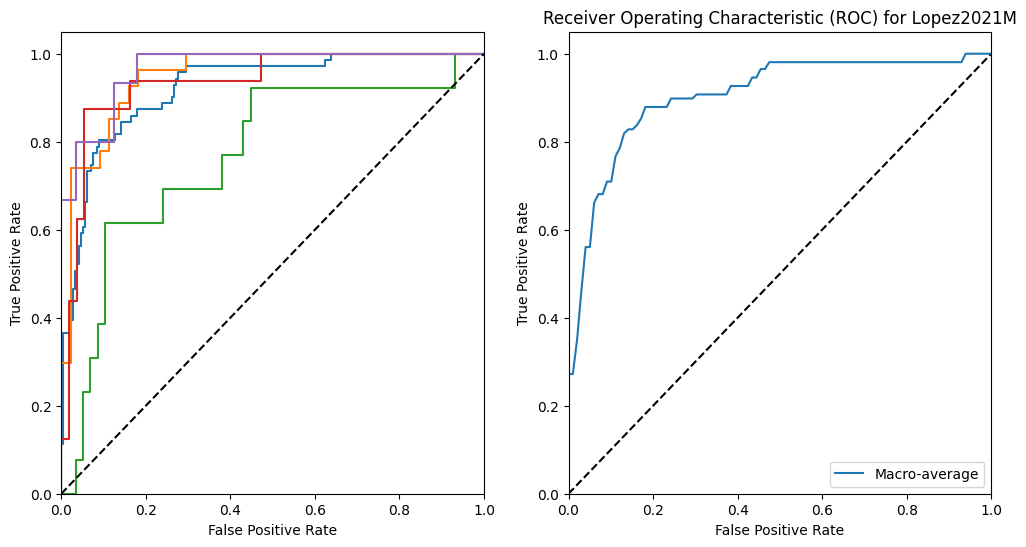

Best threshold based on micro F1 score:
0.72847205


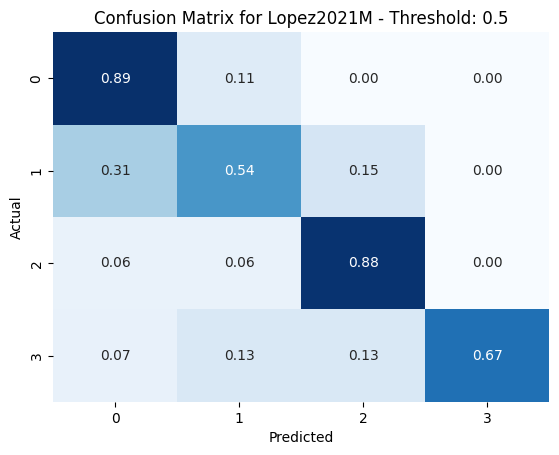

In [30]:
# Plot ROC curves
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(metrics["fpr"]["micro"], metrics["tpr"]["micro"], label='Micro-average (area = {0:0.2f})'.format(metrics["roc_auc"]["micro"]))
for i in range(hp['num_classes']):
    ax[0].plot(metrics["fpr"][i], metrics["tpr"][i], label='Class {0} (area = {1:0.2f})'.format(i, metrics["roc_auc"][i]))

for a in ax:
    a.plot([0, 1], [0, 1], 'k--')
    a.set_xlim([0.0, 1.0])
    a.set_ylim([0.0, 1.05])
    a.set_xlabel('False Positive Rate')
    a.set_ylabel('True Positive Rate')

ax[1].plot(metrics["all_fpr"], metrics["mean_tpr"], label='Macro-average')

plt.title(f'Receiver Operating Characteristic (ROC) for {study_id}')
plt.legend(loc="lower right")
plt.show()

# Print the best threshold based on the macro F1 score
print('Best threshold based on micro F1 score:')

best_threshold = metrics["threshold"]['micro'][np.argmax(metrics["mean_tpr"] - metrics["all_fpr"])]
print(best_threshold)

cm = confusion_matrix(cluster_test, predictions, normalize='true')

sns.heatmap(cm, annot=True, fmt='0.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {study_id} - Threshold: 0.5')
plt.show()


# Training

In [31]:
retrain_all = True
clear_saved_models = True

models = {}

# Uncomment to delete all saved model files
if retrain_all:
    if clear_saved_models:
        for f in os.listdir(output_dir):
            if f.endswith('.json') and "_f1_" in f:
                os.remove(os.path.join(output_dir, f))
    for study_id in set(datasets['study_id']):
        # Load the data
        expr_train, _, cluster_train, _ = load_data(study_id)
        # Load the hyperparameters
        hp = get_hyperparameters(study_id)
        
        params = {
            'device': 'cuda',
            'objective': 'multi:softmax',
            'num_class': hp['num_classes'],
            'max_depth': hp['max_depth'],
            'learning_rate': hp['learning_rate'],
            'gamma': hp['gamma'],
            'n_estimators': hp['n_estimators'],
            'subsample': hp['subsample'],
            'colsample_bytree': hp['colsample_bytree']
        }
        
        # Initialize the model
        model = xgb.XGBClassifier(**params, eval_metric='mlogloss')
        # Train the model
        model.fit(cp.array(expr_train), cp.array(cluster_train))
        # Set feature names
        model.get_booster().feature_names = list(expr_train.columns)
        
        # Evaluate the model on the test set
        _, expr_test, _, cluster_test = load_data(study_id)
        predictions = model.predict(expr_test)
        f1 = f1_score(cluster_test, predictions, average='macro')
        
        # Save the model
        model.save_model(os.path.join(output_dir, f"{study_id}_{pd.Timestamp.now().strftime('%Y%m%d-%H%M%S')}_f1_{f1:.2f}.json"))
        models[study_id] = model        
else:
    for study_id in datasets['study_id']:
        # Load the model from disk
        best_model = find_best_model(study_id)
        if best_model is None:
            print(f"No model found for {study_id}")
            continue
        models[study_id] = xgb.XGBClassifier()
        models[study_id].load_model(os.path.join(output_dir, best_model))

Loaded data for Ruf_Zamojski2021F.
Train: 2030
Test: 508
Loaded data for Ruf_Zamojski2021F.
Train: 2030
Test: 508
Loaded data for Cheung2018M.
Train: 775
Test: 194
Loaded data for Cheung2018M.
Train: 775
Test: 194
Loaded data for Kucka2021F.
Train: 1966
Test: 492
Loaded data for Kucka2021F.
Train: 1966
Test: 492
Loaded data for Fletcher2019M.
Train: 877
Test: 220
Loaded data for Fletcher2019M.
Train: 877
Test: 220
Loaded data for Mayran2019M.
Train: 763
Test: 191
Loaded data for Mayran2019M.
Train: 763
Test: 191
Loaded data for Fletcher2019F.
Train: 628
Test: 157
Loaded data for Fletcher2019F.
Train: 628
Test: 157
Loaded data for Vennekens2021M.
Train: 433
Test: 109
Loaded data for Vennekens2021M.
Train: 433
Test: 109
Loaded data for Allensworth2021F.
Train: 1025
Test: 257
Loaded data for Allensworth2021F.
Train: 1025
Test: 257
Loaded data for Ruf_Zamojski2021M.
Train: 2173
Test: 544
Loaded data for Ruf_Zamojski2021M.
Train: 2173
Test: 544
Loaded data for Lopez2021M.
Train: 283
Test: 7

In [32]:
micro_f1 = []
macro_f1 = []
cm = {}

# Plot the confusion matrix for each dataset
for study_id in set(datasets['study_id']):
    _, expr_test, _, cluster_test = load_data(study_id)
    predictions = models[study_id].predict(cp.array(expr_test))
    cm[study_id] = confusion_matrix(
        cluster_test, predictions, normalize='true')
    macro_f1.append(f1_score(cluster_test, predictions, average='macro'))
    micro_f1.append(f1_score(cluster_test, predictions, average='micro'))

Loaded data for Ruf_Zamojski2021F.
Train: 2030
Test: 508
Loaded data for Cheung2018M.
Train: 775
Test: 194
Loaded data for Kucka2021F.
Train: 1966
Test: 492
Loaded data for Fletcher2019M.
Train: 877
Test: 220
Loaded data for Mayran2019M.
Train: 763
Test: 191
Loaded data for Fletcher2019F.
Train: 628
Test: 157
Loaded data for Vennekens2021M.
Train: 433
Test: 109
Loaded data for Allensworth2021F.
Train: 1025
Test: 257
Loaded data for Ruf_Zamojski2021M.
Train: 2173
Test: 544
Loaded data for Lopez2021M.
Train: 283
Test: 71


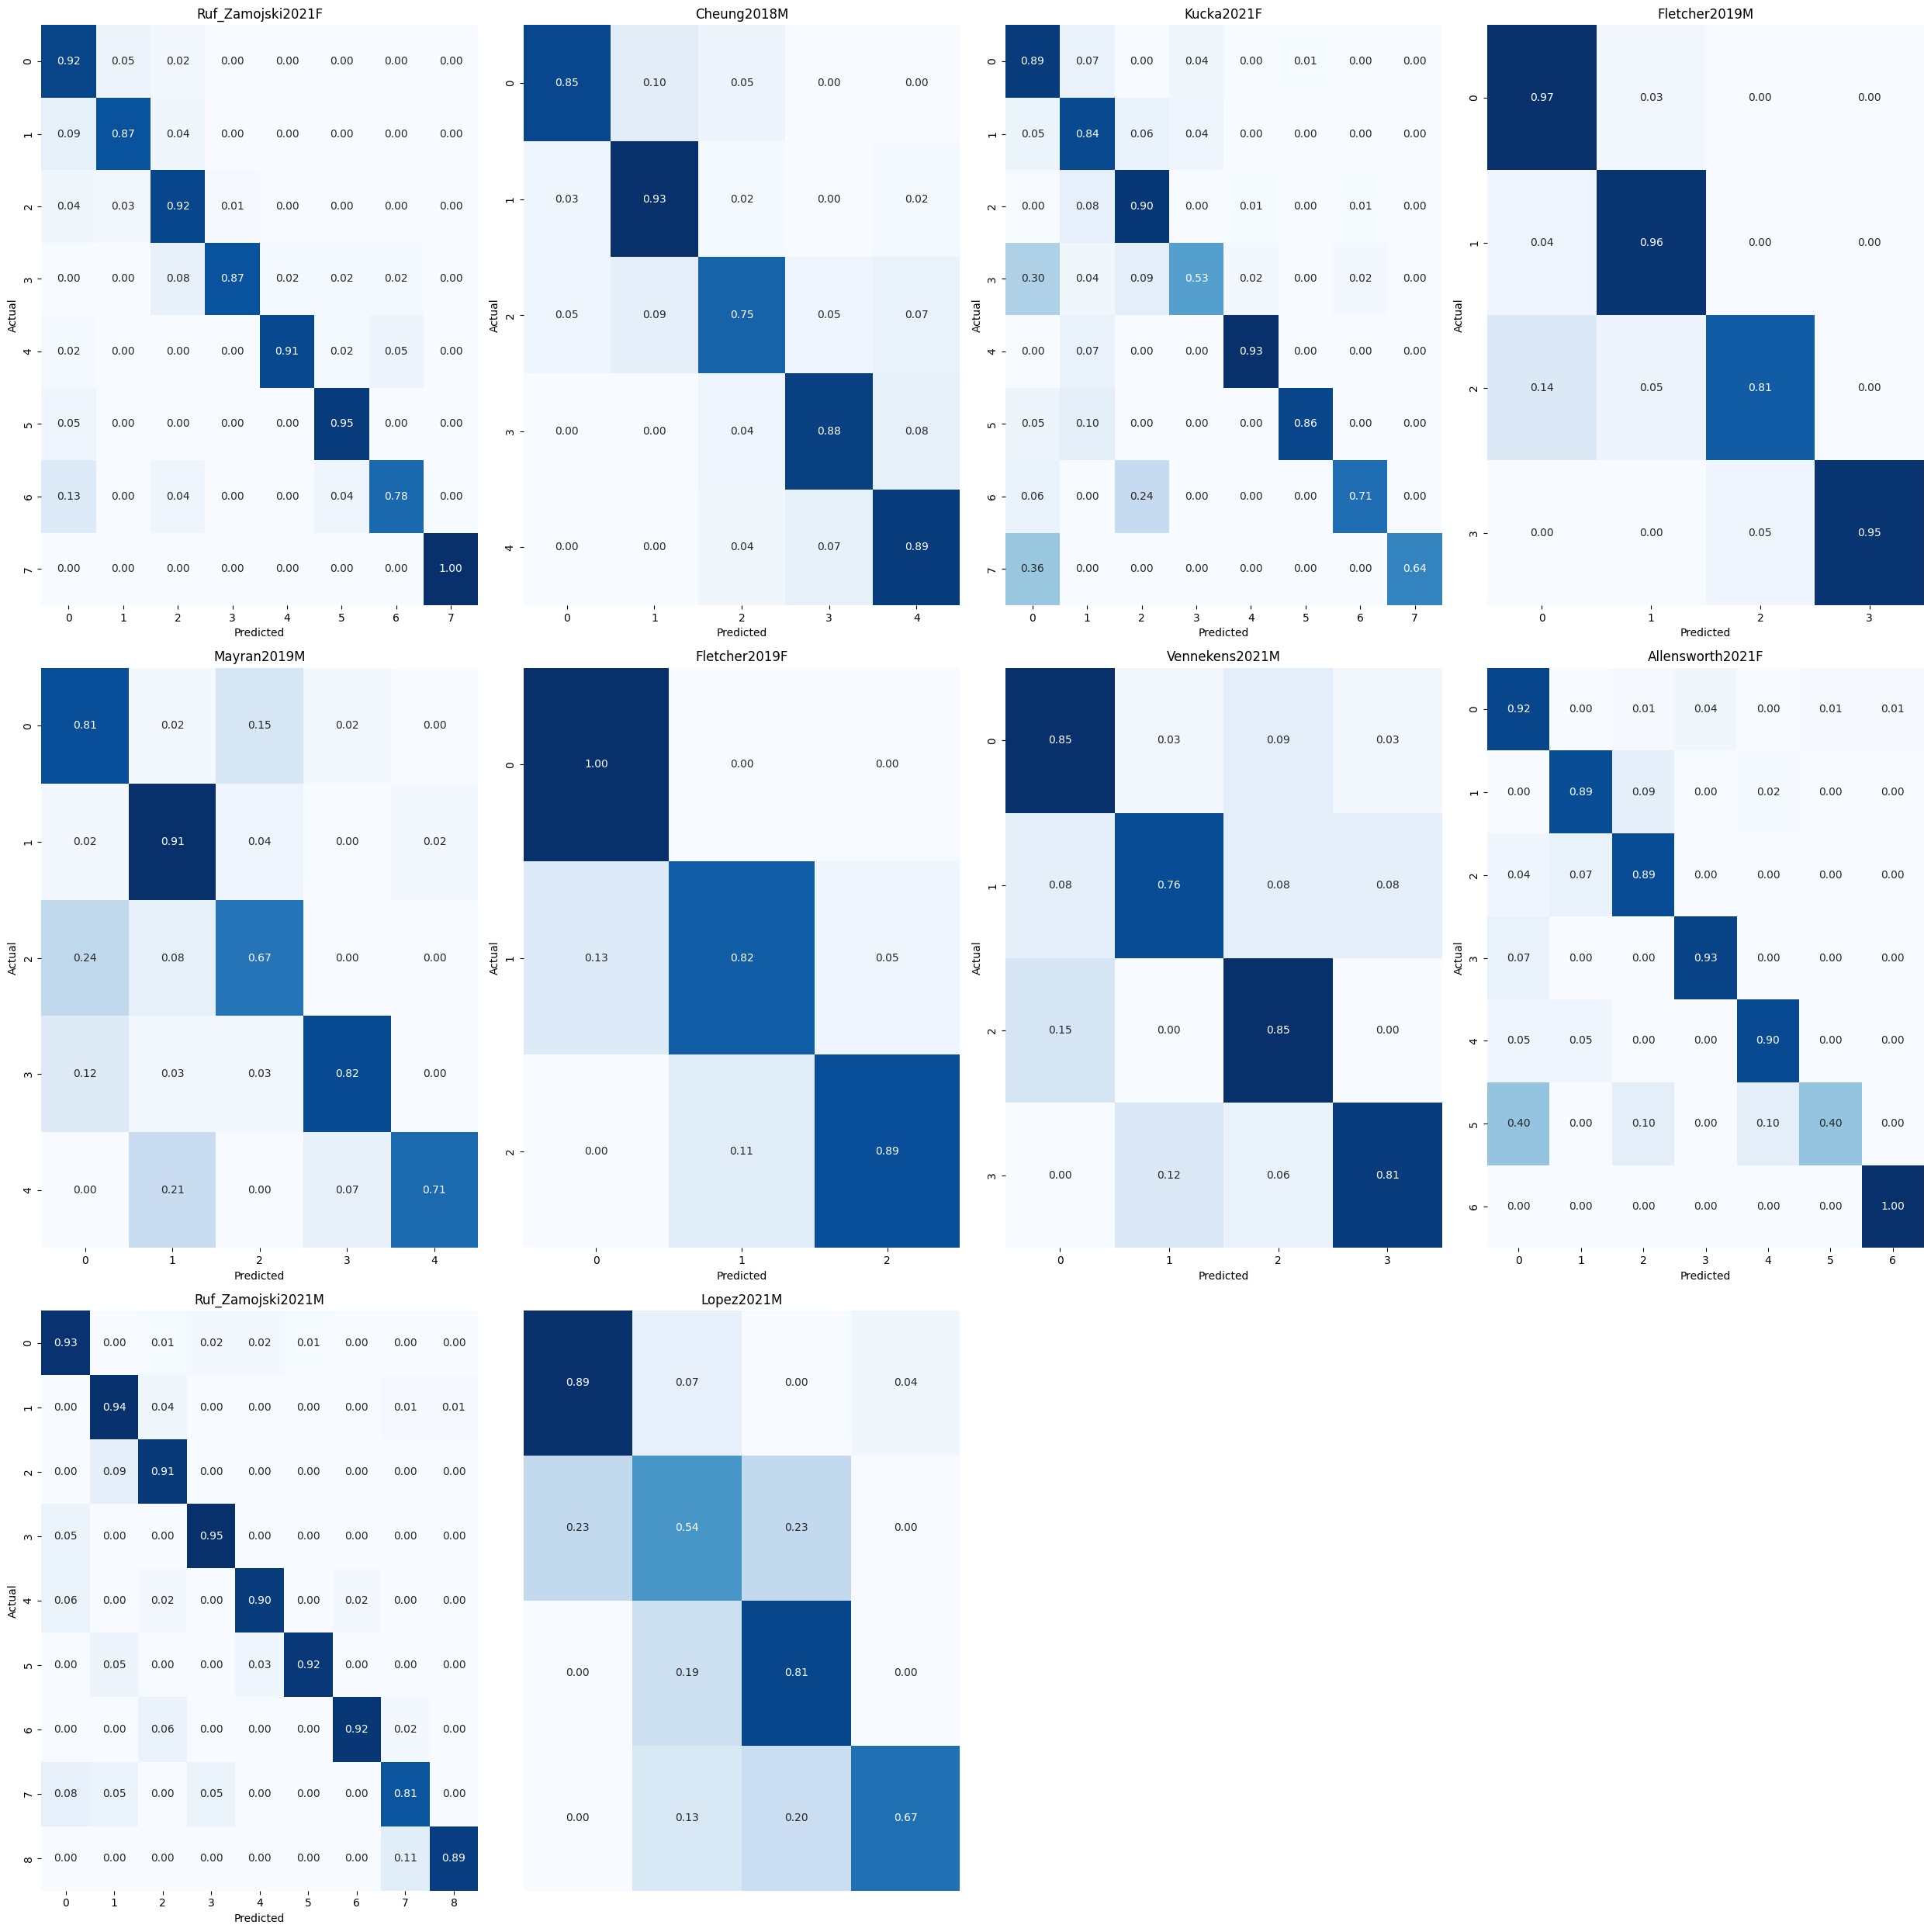

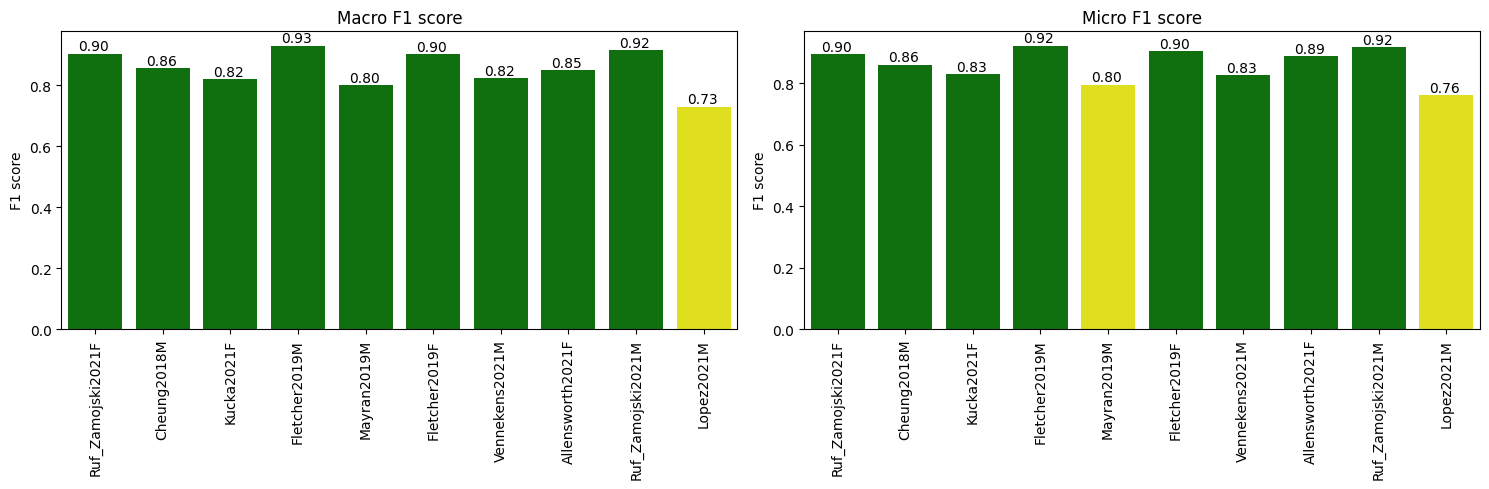

In [33]:
fig, ax = plt.subplots(3, 4, figsize=(25, 25))

for i, study_id in enumerate(set(datasets['study_id'])):
    sns.heatmap(cm[study_id], annot=True, fmt='0.2f',
                cmap='Blues', cbar=False, ax=ax.flat[i])
    ax.flat[i].set_xlabel('Predicted')
    ax.flat[i].set_ylabel('Actual')
    ax.flat[i].set_title(study_id)

for i in range(i, 12):
    ax.flat[i].axis('off')

plt.tight_layout()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x=list(set(datasets['study_id'])), y=macro_f1,
            palette=['red' if f < 0.5 else 'yellow' if f <
                     0.8 else 'green' for f in macro_f1],
            ax=ax[0])
for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)
ax[0].set_title('Macro F1 score')
ax[0].set_ylabel('F1 score')

for i, v in enumerate(macro_f1):
    ax[0].text(i - 0.25, v + 0.01, f"{v:.2f}")

sns.barplot(x=list(set(datasets['study_id'])), y=micro_f1,
            palette=['red' if f < 0.5 else 'yellow' if f <
                     0.8 else 'green' for f in micro_f1],
            ax=ax[1])
for tick in ax[1].get_xticklabels():
    tick.set_rotation(90)
ax[1].set_title('Micro F1 score')
ax[1].set_ylabel('F1 score')

for i, v in enumerate(micro_f1):
    ax[1].text(i - 0.25, v + 0.01, f"{v:.2f}")

plt.tight_layout()

In [34]:
print(f"Mean macro F1 score: {np.mean(macro_f1):.3f}\nMedian macro F1 score: {np.median(macro_f1):.3f}\nStd macro F1 score: {np.std(macro_f1):.3f}")

Mean macro F1 score: 0.853
Median macro F1 score: 0.853
Std macro F1 score: 0.059
